# LSTM for Lorenz96

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from numpy import genfromtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [ ]:

print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)`

Tensorflow version 2.9.2
Running on TPU  ['10.1.139.146:8470']


### We import the data

In [ ]:
%%time 
data = pd.read_csv('/content/drive/My Drive/Data_1millon_8col.csv', header=None, index_col=None)
print(data.shape)
print(data.head())


(1000000, 8)
          0         1         2         3         4         5         6  \
0  1.660793  1.535793  1.556287  1.550895  1.544595  1.526027  1.541284   
1  1.660110  1.535562  1.550808  1.550900  1.544704  1.526028  1.541391   
2  1.659404  1.534874  1.545386  1.550932  1.545030  1.526037  1.541705   
3  1.658648  1.533738  1.540025  1.551017  1.545569  1.526060  1.542214   
4  1.657818  1.532159  1.534731  1.551182  1.546319  1.526103  1.542906   

          7  
0  1.544602  
1  1.550067  
2  1.555477  
3  1.560831  
4  1.566127  
CPU times: user 1.38 s, sys: 186 ms, total: 1.56 s
Wall time: 1.9 s


### We prepare the train, test and validation sets

In [ ]:


# - train 500K (primeros 500K)
# - val 10K (siguientes 40K)
# - test 2K (siguientes 2K)
# training size parameters
train_size = 500000
val_size = 40000
test_size = 2000
 
# lookback

lookback = 5 #

def LSTM_datasets(data,train_size,val_size,test_size):
    samples = train_size + val_size + test_size
    nfeatures = data.shape[1]
    sdata = np.transpose(data.values)[:,:samples]

    X_temp = {}
    for i in range(lookback):    
        X_temp[i] = sdata[:,i:samples-(lookback-i-1)]

    X = X_temp[0]
    for i in range(lookback-1):
        X = np.vstack([X,X_temp[i+1]])

    X = np.transpose(X)
    Y = np.transpose(sdata[:,lookback:samples])

    Xtrain = X[:train_size,:]
    Ytrain = Y[:train_size,:]

    Xval = X[train_size:train_size+val_size,:]
    Yval = Y[train_size:train_size+val_size,:]

    Xtest = X[train_size+val_size:,:]
    Ytest = Y[train_size+val_size:,:]
   
    Xtrain = Xtrain.reshape((Xtrain.shape[0], lookback, nfeatures))
    Xval = Xval.reshape((Xval.shape[0], lookback,nfeatures))
    Xtest = Xtest.reshape((Xtest.shape[0], lookback,nfeatures))
    print("Xtrain shape = ", Xtrain.shape, "Ytrain shape = ", Ytrain.shape)
    print("Xval shape =   ", Xval.shape, "  Yval shape =   ", Yval.shape)
    print("Xtest shape =  ", Xtest.shape, " Ytest shape =  ", Ytest.shape)
    
    return Xtrain,Ytrain,Xval,Yval,Xtest,Ytest,nfeatures


# define the mulitlayer LSTM
nhidden = 30
opt = keras.optimizers.Adam(learning_rate=0.0001)
def LSTM_model(Xtrain,Ytrain,nfeatures,nhidden):
    epochs=10

    model = Sequential()
    model.add(LSTM(nhidden, input_shape=(Xtrain.shape[1], Xtrain.shape[2]))) 
    model.add(Dense(nfeatures))
    model.compile(loss='mse', optimizer=opt)
    # fit network
    history = model.fit(Xtrain, Ytrain,
                        epochs=epochs,
                        batch_size=64,
                        #validation_data=(Xval, Yval), 
                        verbose=1, 
                        shuffle=True)
    model.summary()
    return model, history


# ## Test the model on test data

# test model on set aside test set

def model_predict(model,Xtest):
    ypred = np.zeros((Xtest.shape[0],nfeatures))

    for i in range(Xtest.shape[0]):  
        if i ==0:
            tt = Xtest[0,:,:].reshape((1,lookback,nfeatures))
            ypred[i,:] = model.predict(tt) 
        elif i < lookback:
            tt = Xtest[i,:,:].reshape((1,lookback,nfeatures))
            u = ypred[:i,:]
            tt[0,(lookback-i):lookback,:] = u
            ypred[i,:] = model.predict(tt)
        else:
            tt = ypred[i-lookback:i,:].reshape((1,lookback,nfeatures))
            ypred[i,:] = model.predict(tt)
            
    return ypred




In [ ]:

# ## Run everything

Xtrain,Ytrain,Xval,Yval,Xtest,Ytest,nfeatures =LSTM_datasets(data,train_size,val_size,test_size)
model,history = LSTM_model(Xtrain,Ytrain,nfeatures,nhidden)
ypred = model_predict(model,Xtest)



Xtrain shape =  (500000, 5, 8) Ytrain shape =  (500000, 8)
Xval shape =    (40000, 5, 8)   Yval shape =    (40000, 8)
Xtest shape =   (1996, 5, 8)  Ytest shape =   (1995, 8)
Epoch 1/10
7813/7813 [==============================] - 63s 8ms/step - loss: 0.0870
Epoch 2/10
7813/7813 [==============================] - 61s 8ms/step - loss: 9.0021e-04
Epoch 3/10
7813/7813 [==============================] - 61s 8ms/step - loss: 1.6370e-04
Epoch 4/10
7813/7813 [==============================] - 61s 8ms/step - loss: 5.5973e-05
Epoch 5/10
7813/7813 [==============================] - 60s 8ms/step - loss: 2.7798e-05
Epoch 6/10
7813/7813 [==============================] - 60s 8ms/step - loss: 1.7079e-05
Epoch 7/10
7813/7813 [==============================] - 60s 8ms/step - loss: 1.1928e-05
Epoch 8/10
7813/7813 [==============================] - 60s 8ms/step - loss: 8.9756e-06
Epoch 9/10
7813/7813 [==============================] - 60s 8ms/step - loss: 7.1190e-06
Epoch 10/10
7813/7813 [===============

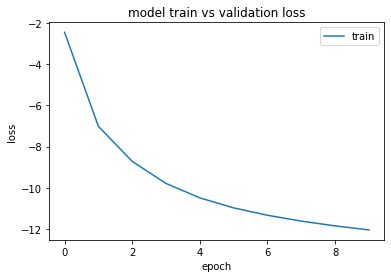

In [ ]:
loss=np.log(history.history['loss'])
#val_loss=np.log(history.history['val_loss'])

plt.plot(loss)
#plt.plot(val_loss)
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Error

**For the analisis on the error we use two parameters**

### **The L2 norm**

$$ e(t)=[\frac{||X_{true}-X_{pred}||}{(||X_{true}||)}]
$$

las ||*|| this is the L2 norm $\sqrt{\sum_{n=1}^{n} (X_t^2) }$

[*] eaverage between the 8 iterations


(*) average set $Δt=2000$

### **The mean squared error**

$$RMSE_t=\sqrt{\frac{1}{V}\sum_{i=1}^{V} ||X_{true}^i-X_{pred}^i||^2 }
$$

In [ ]:
def L2_norm(x,x_p,len,n=8):
  error_L2=np.zeros([len])
  for t in range(len):
    error_L2[t]=np.sum((np.sqrt(np.sum((x[t,:]-x_p[t,:])**2)))/(np.sum((np.sqrt(np.sum((x[t,:])**2))))/len))/n
  return error_L2

  
def RMSE(x,x_p,len,n):
  error=np.zeros([len])
  for t in range(len):
    error[t]=np.sqrt(sum((x[t,:]-x_p[t,:])**2)/n)
  return error

In [ ]:
Ypred=ypred[:-1,:]
Ypred.shape, Ytest[:,7].shape
XX = np.arange(2000-lookback)

error_cuadratico_medio=RMSE(Ytest, Ypred,len=(2000-lookback),n=8)
error_L2=L2_norm(Ytest, Ypred,len=(2000-lookback),n=8)


print(error_cuadratico_medio.shape, error_L2.shape)

(1995,) (1995,)
